# Topic Modeling TDS Posts with Latent Dirichlet Analysis

Based on the tutorial at https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
# !pip install gensim==3.8.3

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# NTLK stopwords
from nltk.corpus import stopwords

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

#saving models
import pickle 
import joblib

import warnings
warnings.filterwarnings("ignore")

In [2]:
#update stopwords with frequent irrelevant words identified during EDA
stop_words = stopwords.words('english')
stop_words.extend(['use', 'used', 'using', 'one', 'like', 'user', 'make', 'also', 'get', 'point', 'let', 'go'])

In [3]:
filename = '../data/cleaned_no_outliers.csv'

In [4]:
#read in the data
df = pd.read_csv(filename)

In [5]:
#remove non-text, non-Y columns
df = df.drop(columns=['date', 'responses', 'author_url',
       'story_url', 'reading_time (mins)', 'number_sections', 
       'number_paragraphs'])

#### Combine Title & Subtitle

In [6]:
df['combined_title'] = (df['title'] + ' ' + df['subtitle'])

In [7]:
df = df.drop(columns = ['title', 'subtitle']).reset_index(drop=True)

#### Remove Punctuation & Make Lowercase

In [8]:
text_cols = ['section_titles', 'paragraphs', 'combined_title']

In [9]:
for col in text_cols:
    df[col] = df[col].map(lambda x: re.sub("[''·,\.!?'-]", '', x).lower())

#### Remove the 'Min Read' Phrase at the Beginning of Each Paragraph

In [10]:
#remove all text up to and including 'min read' in the beginning of the paragraphs
df['paragraphs'] = df['paragraphs'].map(lambda x: (x[x.index('min read')+9:] if (x.count('min read') > 0) else x))
                     

#### Remove the Brackets Surrounding The Section Titles

In [11]:
#remove brackets surrounding the section titles
df['section_titles'] = df['section_titles'].map(lambda x: x.replace("[",""))
df['section_titles'] = df['section_titles'].map(lambda x: x.replace("]",""))

#### Combine Text Columns

In [12]:
df['text'] = df['combined_title'] + df['section_titles'] + df['paragraphs']

In [13]:
df = df.drop(columns = ['section_titles', 'paragraphs', 'combined_title'])

In [14]:
# Convert to list
data = df['text'].values.tolist()

#### Tokenize Words and Clean Up Text

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

data_words = list(sent_to_words(data))

#### Bigram and Trigram Models

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [17]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

#### Remove Stop Words 

In [18]:
data_words_nostops = remove_stopwords(data_words)

#### Initialize Spacy 'en' Model

In [19]:
#!spacy download en_core_web_lg

In [20]:
nlp = spacy.load('en_core_web_lg')

In [21]:
# remove exception from rule-based exceptions - not a fan of "datum" showing up in my corpus along with data....
nlp.get_pipe('lemmatizer').lookups.get_table("lemma_exc")["noun"]["data"] = ["data"]

#### Lemmatize

In [22]:
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV','PROPN'])

#### Form Bigrams & Trigrams

In [23]:
data_words_bigrams = make_bigrams(data_lemmatized)

In [24]:
data_words_trigrams = make_trigrams(data_lemmatized)

### Bigram Modeling

#### Create the Dictionary & Corpus Needed for Topic Modeling

In [25]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [26]:
#check out the dictionary

id2word[0]

'abbreviate'

In [27]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abbreviate', 1),
  ('ability', 1),
  ('able', 2),
  ('ace', 5),
  ('achieve', 1),
  ('actual', 1),
  ('adapt', 1),
  ('addition', 1),
  ('additional', 1),
  ('aim', 1),
  ('airbnb', 1),
  ('algorithm', 5),
  ('allow', 1),
  ('always', 1),
  ('amazon', 1),
  ('amount', 1),
  ('analysis', 1),
  ('analytic', 1),
  ('answer', 3),
  ('appear', 5),
  ('apply', 4),
  ('approach', 3),
  ('approximate', 1),
  ('article', 1),
  ('ask', 7),
  ('aspect', 1),
  ('assumption', 2),
  ('base', 2),
  ('basic', 5),
  ('begin', 1),
  ('benefit', 1),
  ('book', 1),
  ('boost', 1),
  ('breadthfirst_search', 1),
  ('business', 3),
  ('candidate', 9),
  ('capability', 1),
  ('career', 1),
  ('carry', 1),
  ('catch', 1),
  ('categorization', 1),
  ('categorize', 3),
  ('category', 3),
  ('chance', 1),
  ('check', 2),
  ('choice', 3),
  ('choose', 1),
  ('clarify', 1),
  ('classic', 1),
  ('clearly', 2),
  ('code', 45),
  ('coderpad', 1),
  ('codesignal', 1),
  ('coding', 7),
  ('collection', 1),
  ('come'

### Build an LDA Model

Start with standard gensim LDA model

In [28]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [29]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.043*"data" + 0.016*"query" + 0.015*"database" + 0.013*"pipeline" + '
  '0.012*"cloud" + 0.011*"system" + 0.009*"service" + 0.009*"spark" + '
  '0.008*"application" + 0.008*"store"'),
 (1,
  '0.090*"model" + 0.024*"feature" + 0.022*"data" + 0.020*"training" + '
  '0.020*"dataset" + 0.019*"learning" + 0.016*"train" + 0.014*"machine" + '
  '0.012*"prediction" + 0.011*"learn"'),
 (2,
  '0.043*"image" + 0.008*"color" + 0.008*"show" + 0.008*"see" + 0.007*"map" + '
  '0.007*"video" + 0.006*"look" + 0.006*"well" + 0.006*"face" + '
  '0.006*"object"'),
 (3,
  '0.042*"data" + 0.008*"ai" + 0.008*"business" + 0.008*"team" + '
  '0.007*"customer" + 0.006*"company" + 0.006*"year" + 0.006*"product" + '
  '0.005*"system" + 0.005*"analysis"'),
 (4,
  '0.034*"data" + 0.016*"science" + 0.015*"learn" + 0.015*"work" + '
  '0.010*"time" + 0.009*"scientist" + 0.009*"good" + 0.008*"know" + '
  '0.008*"start" + 0.008*"project"'),
 (5,
  '0.016*"value" + 0.016*"variable" + 0.014*"probability" + 0.013*

### Evaluate Topic Model

#### Compute Model Perplexity and Coherence Score

In [30]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.232203979273113

Coherence Score:  0.4472422515860178


Recent studies have "shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, and even sometimes slightly anti-correlated."[*source*](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0#:~:text=Perplexity%20as%20well%20is%20one,used%20for%20language%20model%20evaluation.&text=The%20concept%20of%20topic%20coherence,topics%20inferred%20by%20a%20model.) 

To put it plainly - optimizing for perplexity will not optimize for human interpretability, so in keeping with the spirit of this investigation, I will focus on coherence score to evaluate topic quality. 

Baseline coherence score is 0.4472 with gensim's standard LDA algorithm, but the literature indicates that the LDA mallet algorithm may perform better. 

#### Visualize

In [33]:
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(lda_model, corpus, id2word)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/LDA_TDS10.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.011733 -0.011033       1        1  17.920223
3      0.054281 -0.180097       2        1  15.271733
7     -0.004594  0.179027       3        1  11.784720
1     -0.033649  0.001675       4        1  11.420534
8      0.158117  0.204257       5        1   9.896258
5     -0.149477  0.001599       6        1   9.606256
6     -0.074248  0.036955       7        1   8.509534
2     -0.132620 -0.083003       8        1   6.034793
0      0.280724 -0.117673       9        1   4.825953
9     -0.110267 -0.031706      10        1   4.729995, topic_info=          Term           Freq          Total Category  logprob  loglift
242      model   60849.000000   60849.000000  Default  30.0000  30.0000
80        data  115226.000000  115226.000000  Default  29.0000  29.0000
940      image   18972.000000   18972.000000  Default  28.0000  28.0000
933   function   25816.000000   25816.000000  Default  27.0000  27.0000
416       word   11384.000000   11384.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
23     article    1499.108254   17525.155050  Topic10  -5.1185   0.5925
1661     state    1283.908380    7442.208271  Topic10  -5.2734   1.2940
1299     score    1242.844126    5310.246088  Topic10  -5.3059   1.5990
327     search    1219.219584    4636.893122  Topic10  -5.3251   1.7154
405     vector    1220.510715    5860.264179  Topic10  -5.3241   1.4823

[745 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1124      2  0.033898  accuracy
1124      4  0.958095  accuracy
1124      6  0.007903  accuracy
2300      1  0.012201    action
2300      2  0.211758    action
...     ...       ...       ...
420       1  0.320856      year
420       2  0.556150      year
420       3  0.044176      year
420       6  0.020809      year
420       8  0.057894      year

[1916 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 8, 2, 9, 6, 7, 3, 1, 10])

There is lots of overlap and clustering of topics on the left side of the axes. I will try the Mallet algorithm next to improve topic quality.

### Build LDA Mallet Model

In [34]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models.wrappers import LdaMallet

In [36]:
#start with 10 topics & fit model to compare to previous
mallet_path = '/Users/rachelinsler/dsi/downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

#### Evaluate with Coherence Score & Visualization

In [51]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
#display coherence score
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4705005301363113


Coherence score has improved for the 10-topic model. 

In [52]:
# the pyLDAvis was throwing errors on the mallet model; so I found this code on stackoverflow: https://stackoverflow.com/questions/54684552/issue-with-topic-word-distributions-after-malletmodel2ldamodel-in-gensim
from gensim.models.ldamodel import LdaModel

def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha, eta=0, iterations=1000, gamma_threshold=0.001, dtype=np.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [53]:
converted_model = ldaMalletConvertToldaGen(ldamallet)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/LDAmallet_TDS10.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.087462 -0.047303       1        1   9.408990
1     -0.237159  0.153135       2        1   9.393088
2      0.005070 -0.051212       3        1   7.542113
3     -0.023979  0.183015       4        1  11.649825
4      0.256683  0.132767       5        1  10.318979
5     -0.028037 -0.179705       6        1  12.047225
6     -0.132965 -0.153875       7        1  10.695639
7     -0.056319  0.177497       8        1  11.024835
8      0.208032 -0.074486       9        1   8.793027
9     -0.078788 -0.139832      10        1   9.126280, topic_info=             Term           Freq          Total Category  logprob  loglift
80           data  126369.000000  126369.000000  Default  30.0000  30.0000
242         model   65839.000000   65839.000000  Default  29.0000  29.0000
933      function   29638.000000   29638.000000  Default  28.0000  28.0000
50           code   26696.000000   26696.000000  Default  27.0000  27.0000
940         image   19307.000000   19307.000000  Default  26.0000  26.0000
...           ...            ...            ...      ...      ...      ...
1007        small    1913.601699    6889.724262  Topic10  -5.5316   1.1130
183   information    2040.869424   10974.351467  Topic10  -5.4672   0.7118
910        define    1951.438001    8076.973743  Topic10  -5.5120   0.9736
761        result    2139.473168   18196.028564  Topic10  -5.4200   0.2534
331           set    2084.438567   19661.647306  Topic10  -5.4461   0.1498

[983 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
423        3  0.971304      abcd
6798       4  0.999762  academia
1555       2  0.091214    access
1555       5  0.531910    access
1555       8  0.197596    access
...      ...       ...       ...
420        8  0.079155      year
1817       7  0.877006     ymean
1343       7  1.052407    youden
10408      6  1.005690      zhou
2905      10  0.872177        ³⁰

[1896 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

The spread of topics has improved for the 10 topic model. I will continue using the Mallet algorithm and search over a range of #s of topics to settle on the optimal number, using coherence score as my evaluation metric

#### Compute Optimal Number of Topics Based on Coherence

In [54]:
# an adapted version of a function to compute coherence values over a range of total topic numbers
# https://github.com/RaRe-Technologies/gensim/issues/2500

def compute_coherence_values(dictionary, all_corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    num_topics_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=all_corpus, num_topics=num_topics, id2word=dictionary,
                                         random_seed=42)
        #model = gensim.models.ldamodel.LdaModel(corpus=all_corpus,num_topics=num_topics,id2word=dictionary,eval_every=1,
        #                                        alpha='auto',random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        num_topics_list.append(num_topics)

    return model_list, coherence_values, num_topics_list

In [55]:
# calculate coherence values over the specific range of numbers of topics

model_list, coherence_values, num_topics_list = compute_coherence_values(dictionary=id2word,all_corpus=corpus,
                                                                         texts=data_words_bigrams,start=4,limit=30, step=2)

#store the results in a dataframe
model_values_df = pd.DataFrame({'model_list':model_list,'coherence_values':coherence_values,'num_topics':num_topics_list})

#find the number of topics that corresponds to the maximum coherence value
optimal_num_topics = model_values_df.loc[model_values_df['coherence_values'].idxmax()]['num_topics']

#save this as as the optimal model
optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=optimal_num_topics, id2word=id2word, random_seed=42)

In [56]:
#save optimal models
joblib.dump(id2word,'id2word_dictionary_mallet.pkl')
joblib.dump(optimal_model,'optimal_ldamallet_model.pkl')

['optimal_ldamallet_model.pkl']

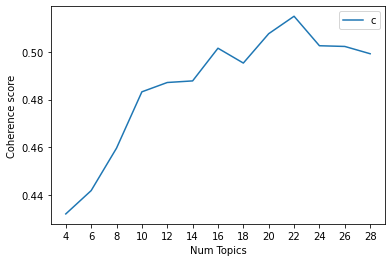

In [58]:
# Show coherence values graph
limit=30; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(ticks=range(4,30,2))
plt.legend(("coherence_values"), loc='best')
plt.show()

Coherence score is highest for 22 topics. 

### Create & Visualize Model with Optimal Number of Topics

#### LDA Mallet Model: 22 Topics

In [72]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.514920708296126


In [68]:
#convert and visualize
converted_model = ldaMalletConvertToldaGen(optimal_model)
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(converted_model, corpus, id2word, sort_topics=False)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, '../figures/LDA_mallet_22.html')
plot

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.111229 -0.146036       1        1  4.191639
1     -0.019785  0.163204       2        1  4.188703
2      0.146661 -0.058900       3        1  4.818280
3     -0.068613 -0.033505       4        1  5.372389
4      0.181582  0.188321       5        1  4.991012
5      0.178994 -0.033204       6        1  5.180188
6      0.104953 -0.235154       7        1  4.292707
7     -0.079843 -0.124872       8        1  3.877037
8     -0.190221  0.077925       9        1  4.889616
9     -0.038762  0.112834      10        1  3.419930
10    -0.108663 -0.210289      11        1  4.879762
11    -0.184555  0.034458      12        1  4.268121
12     0.132927  0.030394      13        1  6.121540
13    -0.114244 -0.002314      14        1  4.667560
14     0.251368  0.089869      15        1  5.457289
15    -0.168383  0.139467      16        1  4.854911
16     0.110059  0.043042      17        1  4.736304
17    -0.063183 -0.016591      18        1  4.171320
18     0.062980  0.065419      19        1  3.143099
19    -0.138239  0.087470      20        1  4.201522
20     0.079771 -0.288110      21        1  4.763252
21     0.036425  0.116570      22        1  3.513819, topic_info=          Term           Freq          Total Category  logprob  loglift
80        data  126888.000000  126888.000000  Default  30.0000  30.0000
242      model   65727.000000   65727.000000  Default  29.0000  29.0000
933   function   29330.000000   29330.000000  Default  28.0000  28.0000
940      image   19398.000000   19398.000000  Default  27.0000  27.0000
572    feature   21062.000000   21062.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
1282      rate     824.215475    4313.733333  Topic22  -5.4194   1.6933
1259     order     923.769565    8289.081663  Topic22  -5.3054   1.1542
384       time    1014.062824   29502.815461  Topic22  -5.2121  -0.0221
153       good     915.666305   18020.031954  Topic22  -5.3142   0.3689
761     result     914.508734   18193.859025  Topic22  -5.3155   0.3580

[2134 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
3978       6  0.882984       aaw
423       19  0.965176      abcd
2909       2  1.013338    abroad
1555       2  0.014159    access
1555       3  0.137695    access
...      ...       ...       ...
31673      6  0.990013  youtuber
7809      20  1.044319        y₂
2904       5  0.887174     ³bear
2905      16  0.875181        ³⁰
2906       5  0.887174     ¹note

[5456 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

### Find the Dominant Topic in Each Document

In [74]:
# adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

def format_topics_docs(ldamodel=lda_model, corpus=corpus, texts=data_words_bigrams):
    # Init output
    docs_topics_df = pd.DataFrame()
 
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                docs_topics_df = docs_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]),ignore_index=True)
            else:
                break
    docs_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    docs_topics_df = pd.concat([docs_topics_df, contents], axis=1)
    return(docs_topics_df)

In [78]:
df_topic_docs_keywords = format_topics_docs(ldamodel=converted_model, corpus=corpus, texts=data_words_bigrams)# Format
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']# Show
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,14.0,0.4002,"scientist, science, work, company, business, j...","[ultimate, guide, ace, code, interview, data, ..."
1,1,18.0,0.3597,"video, time, face, signal, car, system, audio,...","[shakespeare, eminem, well, lyricist, know, po..."
2,2,13.0,0.3274,"image, network, layer, deep, dataset, input, l...","[implement, pytorch, guy, happy, new, year, to..."
3,3,0.0,0.2017,"column, table, data, panda, row, dataframe, qu...","[stock_price, analysis, panda, altair, practic..."
4,4,8.0,0.5373,"feature, dataset, algorithm, cluster, class, c...","[optimal, threshold, imbalanced, classificatio..."
5,5,13.0,0.5529,"image, network, layer, deep, dataset, input, l...","[create, abstract, art, stylegan_ada, adaptive..."
6,6,17.0,0.3103,"word, text, document, sentence, language, nlp,...","[natural_language, generation, part, gpt, hugg..."
7,7,3.0,0.1635,"model, training, train, learning, prediction, ...","[dangerously, underdiscussed, problem, face, m..."
8,8,15.0,0.1442,"distribution, probability, variable, test, sam...","[project, modeling, predict, churn, customer, ..."
9,9,11.0,0.2132,"function, weight, output, input, parameter, er...","[lesserknown, useful, sklearn, model, interest..."


#### Find the most representative document for each topic

In [88]:
# Group top 5 documents under each topic
doc_topics_sorteddf_mallet = pd.DataFrame()

doc_topics_outdf_grpd = df_topic_docs_keywords.groupby('Dominant_Topic')

for i, grp in doc_topics_outdf_grpd:
    doc_topics_sorteddf_mallet = pd.concat([doc_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
doc_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
doc_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
doc_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7637,"column, table, data, panda, row, dataframe, qu...","[example, master, sql, comprehensive, practica..."
1,1.0,0.7040,"time, series, year, price, day, country, analy...","[mobility, change, south_africa, analysis, mob..."
2,2.0,0.7067,"pipeline, system, cloud, spark, run, process, ...","[understand, apache_spark, resource, task, man..."
3,3.0,0.5374,"model, training, train, learning, prediction, ...","[crossvalidation, testing, machine, learning, ..."
4,4.0,0.7267,"ai, system, human, research, people, bias, wor...","[view, ai, risk, understand, dark, side, ai, r..."


### Topic distribution across documents

In [ ]:
#not sure what is goign on here

In [89]:
# Number of Documents for Each Topic
topic_counts = df_topic_docs_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_docs_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.isnull().sum()

Dominant_Topic       0
Topic_Keywords       0
Num_Documents     9268
Perc_Documents    9268
dtype: int64